# Import libraries

In [1]:
!nvidia-smi

Tue Sep 28 22:35:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.12       Driver Version: 472.12       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000       WDDM  | 00000000:02:00.0 Off |                  Off |
| 28%   45C    P8    N/A /  N/A |    538MiB / 16384MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro P5000       WDDM  | 00000000:03:00.0  On |                  Off |
| 26%   

In [441]:
import hyperspy.api as hs
import os
import time
import numpy as np
import pandas as pd
import random
import itertools
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 
from scipy import ndimage as ndi
from sklearn.cluster import MeanShift
from skimage import io, img_as_float
from scipy import fftpack

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms

#%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import seaborn as sns
from hyperspy.io_plugins.bruker import bcf_reader, BCF_reader
#from tsnecuda import TSNE

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
same_seeds(1)

# Read Dataset

In [3]:
bcf_dataset = hs.load('bcf_files/XLI_exhaust_011.bcf')# XLI_exhaust_011 # BSE_24 #'map06_15kV_30um_ss4_13mm_15min.bcf')

bse, edx = bcf_dataset[0], bcf_dataset[2] #load BSE and EDX data from bcf file
edx.change_dtype('float32') # change edx data from unit8 into float32

print(edx.metadata)

├── Acquisition_instrument
│   └── SEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 45.0
│       │       ├── detector_type = XFlash 6|30
│       │       ├── elevation_angle = 35.0
│       │       ├── energy_resolution_MnKa = 130.0
│       │       ├── live_time = 653.257
│       │       └── real_time = 703.196928
│       ├── Stage
│       │   ├── rotation = 0.025
│       │   ├── tilt_alpha = 0
│       │   ├── x = 26284.0
│       │   ├── y = -1347.0
│       │   └── z = 13000.6829156682
│       ├── beam_energy = 15.0
│       └── magnification = 10191.26669
├── General
│   ├── date = 2021-07-24
│   ├── original_filename = XLI_exhaust_011.bcf
│   ├── time = 10:31:40
│   └── title = EDX
├── Sample
│   ├── elements = ['Al', 'C', 'Ca', 'Cl', 'Cr', 'Fe', 'Mn', 'O', 'Si']
│   ├── name = Undefinded
│   └── xray_lines = ['Al_Ka', 'C_Ka', 'Ca_Ka', 'Cl_Ka', 'Cr_Ka', 'Fe_Ka', 'Mn_Ka', 'O_Ka', 'Si_Ka']
└── Signal
    ├── binned = True
    ├── quantity = X-rays (Counts)


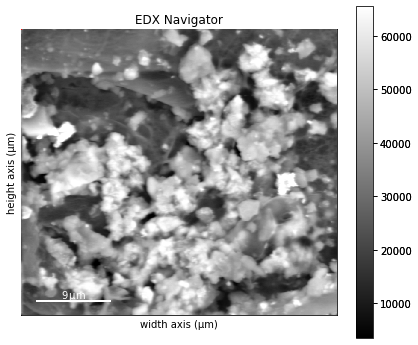

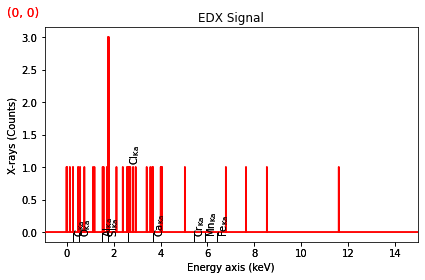

In [4]:
edx.plot(xray_lines=True, navigator=bse)

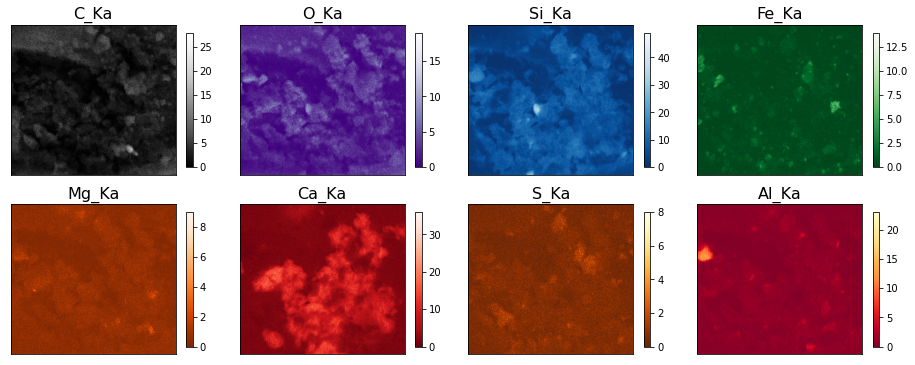

In [5]:
def plot_intensity_maps(edx, element_list, grid_dims=(2,4)):
  cmaps = ['Greys_r', 'Purples_r', 'Blues_r', 'Greens_r', 'Oranges_r', 'Reds_r', 'YlOrBr_r', 'YlOrRd_r'] #['Blues_r', 'YlOrBr_r', 'Greens_r', 'Reds_r', 'Purples_r', 'pink', 'bone', 'viridis']
  nrow = grid_dims[0]
  ncol = grid_dims[1]

  fig, axs = plt.subplots(nrows=nrow, ncols=ncol, sharex=True, sharey=True, figsize=(4*ncol,3.3*nrow))
  for i in range(nrow):
    for j in range(ncol):
      el = element_list[(i*ncol)+j]
      map = edx.get_lines_intensity([el])[0].data
      im = axs[i,j].imshow(map, cmap=cmaps[(i*ncol)+j])
      axs[i,j].set_yticks([])
      axs[i,j].set_xticks([])
      axs[i,j].set_title(el, fontsize=16)
      fig.colorbar(im, ax=axs[i,j], shrink=0.75)

  fig.subplots_adjust(wspace=0.11, hspace=0.)


element_list = ['C_Ka', 'O_Ka', 'Si_Ka', 'Fe_Ka', 'Mg_Ka', 'Ca_Ka','S_Ka', 'Al_Ka']
plot_intensity_maps(edx, element_list, grid_dims=(2,4))

# Clean data

## Remove first peak

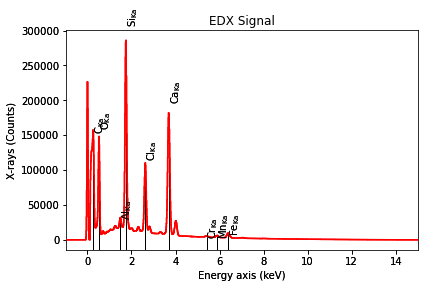

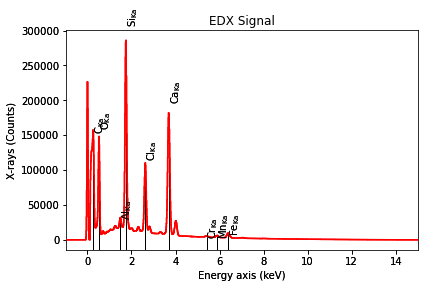

In [6]:
# plot the profile before cleaning
edx.sum().plot(xray_lines=True) 

# cleaning
for i in range(58):
  edx.isig[i] = 0

# plot the profile after cleaning
edx.sum().plot(xray_lines=True)

## Bin EDX intensity

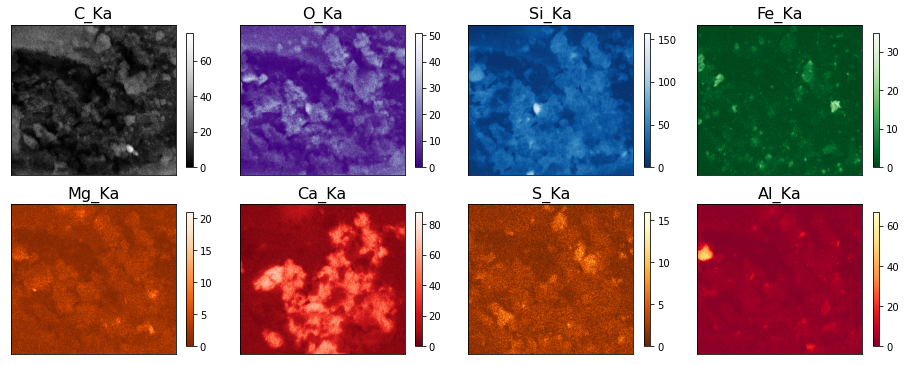

In [7]:
edx_2xbin = edx.rebin(scale=(2, 2, 1))
bse_2xbin = bse.rebin(scale=(2, 2))

plot_intensity_maps(edx_2xbin, element_list)

## Normalise intensity along each channel

In [8]:
def normalize_hs(s):
  s_norm = s #.deepcopy()
  s_norm.data = s_norm.data / s_norm.data.sum(axis=2, keepdims = True)
  return s_norm

edx_norm = normalize_hs(edx_2xbin)
edx_norm

<EDSSEMSpectrum, title: EDX, dimensions: (369, 336|1595)>

## Noise reduction using PCA

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=10
  centre=None


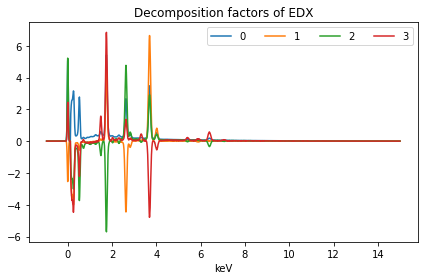

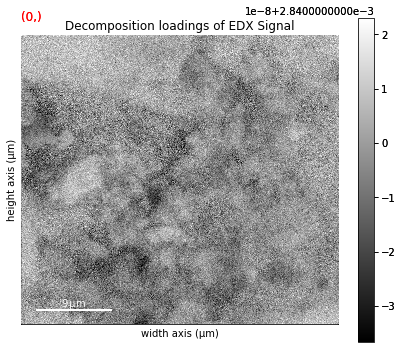

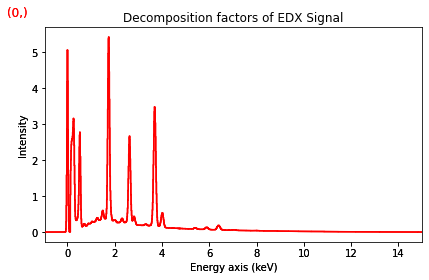

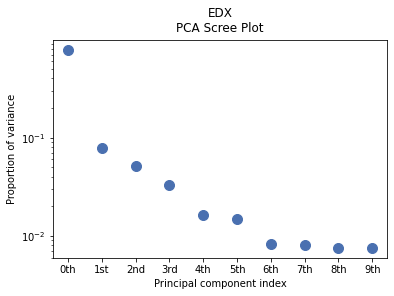

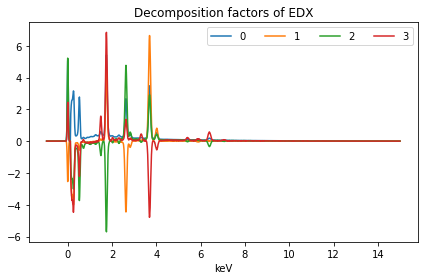

In [9]:
edx_norm.decomposition(normalize_poissonian_noise=True, algorithm='SVD', random_state=0, output_dimension=10)
edx_norm.plot_decomposition_results()
edx_norm.plot_explained_variance_ratio(log=True)
edx_norm.plot_decomposition_factors(comp_ids=4)

## Select EDX peaks

[<BaseSignal, title: X-ray line intensity of EDX: O_Ka at 0.52 keV, dimensions: (369, 336|)>,
 <BaseSignal, title: X-ray line intensity of EDX: Fe_Ka at 6.40 keV, dimensions: (369, 336|)>,
 <BaseSignal, title: X-ray line intensity of EDX: Mg_Ka at 1.25 keV, dimensions: (369, 336|)>,
 <BaseSignal, title: X-ray line intensity of EDX: Ca_Ka at 3.69 keV, dimensions: (369, 336|)>,
 <BaseSignal, title: X-ray line intensity of EDX: Al_Ka at 1.49 keV, dimensions: (369, 336|)>,
 <BaseSignal, title: X-ray line intensity of EDX: C_Ka at 0.28 keV, dimensions: (369, 336|)>,
 <BaseSignal, title: X-ray line intensity of EDX: Si_Ka at 1.74 keV, dimensions: (369, 336|)>,
 <BaseSignal, title: X-ray line intensity of EDX: S_Ka at 2.31 keV, dimensions: (369, 336|)>]

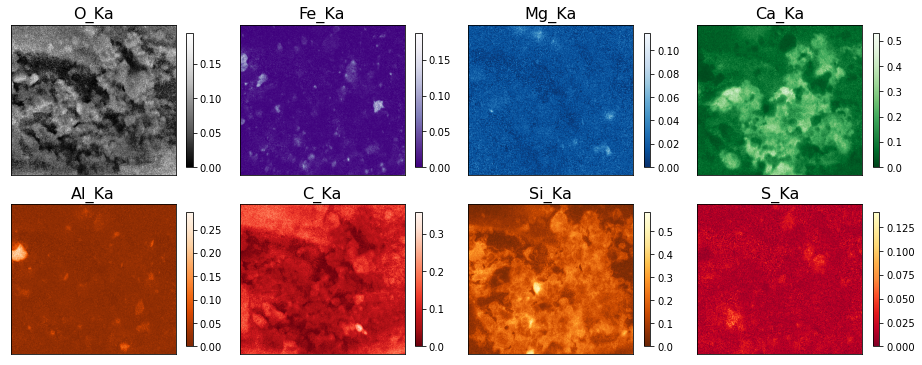

In [10]:
feature_list = ['O_Ka','Fe_Ka','Mg_Ka','Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka','S_Ka']
plot_intensity_maps(edx_norm, feature_list, grid_dims=(2,4))
edx_norm.get_lines_intensity(feature_list)

In [11]:
def get_features(s, feature_list):
    lines = s.get_lines_intensity(feature_list)
    dims = lines[0].data.shape
    data_cube = np.zeros((dims[0], dims[1], len(feature_list)))

    for i in range(len(feature_list)):
        data_cube[:, :, i] = lines[i]

    return data_cube#.reshape(-1, len(feature_list))

# Instance Normalisation
def InsNorm(dataset):
    for i in range(dataset.shape[2]):
      mean = dataset[:,:,i].mean()
      std = dataset[:,:,i].std()
      dataset[:,:,i] = (dataset[:,:,i] - mean) / std
    return dataset

def InsNorm_ms(dataset):
    means = []
    stds = []
    for i in range(dataset.shape[2]):
      mean = dataset[:,:,i].mean()
      std = dataset[:,:,i].std()
      dataset[:,:,i] = (dataset[:,:,i] - mean) / std
      means.append(mean)
      stds.append(std)
    return dataset, np.stack(means,axis=0), np.stack(stds,axis=0)

# Batch Normalisation
def BatchNorm(dataset):
    dataset = dataset / np.sum(dataset, axis=2)[:,:,np.newaxis]
    dataset = np.nan_to_num(dataset)
    return dataset

# Add Phase Features
def AddPhase(dataset):
    phases=[]
    coms = itertools.combinations(range(dataset.shape[2]),2)
    for (i,j) in coms:
      phase = 0.5 * (dataset[:,:,i] + dataset[:,:,j])
      phases.append(phase)
  
    phases_ = np.stack(phases, axis=2)
    dataset = np.concatenate([dataset,phases_],axis=2)
    return dataset

In [12]:
dataset = get_features(edx_norm, feature_list=feature_list)
dataset = InsNorm(dataset) 
dataset.shape

(336, 369, 8)

## Integrate background signal

In [13]:
def getBackgroundSignal(dataset:np)->np:
    h = dataset.shape[0]
    w = dataset.shape[1]    
    new_dataset = np.zeros(shape=dataset.shape)
    for i in range(h):
        for j in range(w):
            i_idxs=[i-1,i,i+1]
            j_idxs=[j-1,j,j+1]
            for i_idx in i_idxs:
                if i_idx < 0 or i_idx >= dataset.shape[0]:
                    i_idxs.remove(i_idx)
            for j_idx in j_idxs:
                if j_idx < 0 or j_idx >= dataset.shape[1]:
                    j_idxs.remove(j_idx)
            positions = [position for position in itertools.product(i_idxs,j_idxs)]
            background_signal = []
            for k in positions:
                background_signal.append(dataset[k])
            background_signal = np.stack(background_signal,axis=0)
            background_signal_avg = np.sum(background_signal,axis=0) / background_signal.shape[0]

            new_dataset[i,j,:] = background_signal_avg
         
    return new_dataset

new_dataset = getBackgroundSignal(dataset)
#new_dataset = InsNorm(new_dataset) 
features = new_dataset.reshape(-1,new_dataset.shape[2])
print('Size of features: ', features.shape)

Size of features:  (123984, 8)


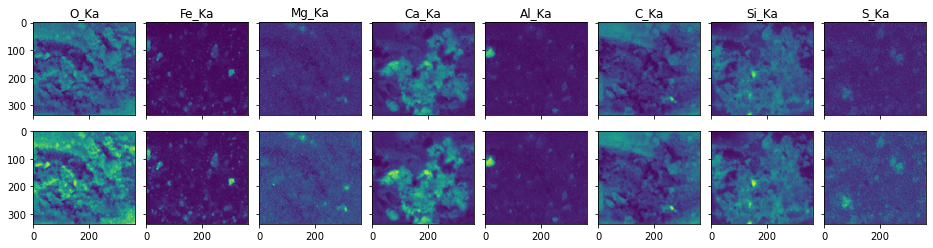

In [14]:
fig, axs = plt.subplots(nrows=2,ncols=8,sharex=True,sharey=True,figsize=(16,4))
for i in range(2):
    for j in range(8):
        if i == 0:
            axs[i,j].set_title(feature_list[j])
            axs[i,j].imshow(dataset[:,:,j], cmap='viridis')
        else:
            axs[i,j].imshow(new_dataset[:,:,j], cmap='viridis')

fig.subplots_adjust(wspace=0.11, hspace=0.)

# Neural Network

In [232]:
class FeatureDataset(Dataset):
    def __init__(self, x):
        if len(x.shape)==2:
            self.x = x
        else:
            self.x = x.reshape(-1, x.shape[-1])

    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return torch.Tensor(self.x[idx])

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class AutoEncoder(nn.Module):
    def __init__(self, in_channel):
        super(AutoEncoder, self).__init__()
        self.in_channel = in_channel

        self.encoder = nn.Sequential(nn.Linear(self.in_channel,512),
                                     nn.LayerNorm(512),
                                     nn.LeakyReLU(0.02),
                                     
                                     nn.Linear(512,256),
                                     nn.LayerNorm(256),
                                     nn.LeakyReLU(0.02),
                                     
                                     nn.Linear(256,128),
                                     nn.LayerNorm(128),
                                     nn.LeakyReLU(0.02),
                                     
                                     nn.Linear(128,2)
                                    )

        self.decoder = nn.Sequential(nn.Linear(2,128),
                                     nn.LayerNorm(128),
                                     nn.LeakyReLU(0.02),
                                     
                                     nn.Linear(128,256),
                                     nn.LayerNorm(256),
                                     nn.LeakyReLU(0.02),
                                     
                                     nn.Linear(256,512),
                                     nn.LayerNorm(512),
                                     nn.LeakyReLU(0.02),
                                     
                                     nn.Linear(512,self.in_channel),
                                    )
        
        self.apply(weights_init)
    
    def _encode(self, x):
        return self.encoder(x)
    
    def _decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        z = self._encode(x)
        x_recon = self._decode(z)
        return x_recon

## Training parameters

In [233]:
params = dict()
params['num_epoch'] = 50
params['batch_size'] = 64
params['lr'] = 1e-4
params['weight_decay'] = 0

## Building models

In [275]:
# Dealing with training and testing sets, and make them fitting into

#bse_dataset = np.concatenate([np.expand_dims(bse_2xbin.data, axis=-1), new_dataset],axis=2)
#bse_dataset = InsNorm(bse_dataset)

train_data, test_data = train_test_split(new_dataset.reshape(-1,new_dataset.shape[-1]), test_size=0.1, random_state=42)
feature_dataset = FeatureDataset(new_dataset.reshape(-1,new_dataset.shape[-1]))
test_dataset = FeatureDataset(test_data)
feature_loader = DataLoader(feature_dataset, batch_size=params['batch_size'],shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024,shuffle=False)

input_size = feature_dataset.__getitem__(0).size(0)

# Buld a model, optimizer, and loss function
model = AutoEncoder(in_channel=input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'],weight_decay=params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True, patience = 5, threshold=1e-2, min_lr=1e-7)
criterion = nn.MSELoss()

## Training

In [276]:
def train(model, optimizer, train_loader, test_loader, params):
    num_epoch = params['num_epoch']
    for epoch in range(num_epoch):
        # Training
        model.train()
        t = time.time()
        total_loss = []
        for i, data in enumerate(train_loader):
            x = data.to(device)
            x_recon = model(x)
            loss = criterion(x_recon, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.detach().item())
        
        # Testing
        model.eval()
        test_loss = []
        for i, test in enumerate(test_loader):
            x = test.to(device)
            x_recon = model(x)
            loss = criterion(x_recon, x)
            test_loss.append(loss.item())
        
        # Logging
        avg_loss = sum(total_loss) / len(total_loss)
        avg_test = sum(test_loss) / len(test_loss)
        training_time = time.time() - t
        
        print(f'[{epoch+1:03}/{num_epoch:03}] train_loss: {avg_loss:.3f}, test_loss: {avg_test:.3f}, time: {training_time:.2f} s')
        
        scheduler.step(avg_test)

train(model, optimizer, feature_loader, test_loader, params)

[001/050] train_loss: 0.110, test_loss: 0.092, time: 13.35 s
[002/050] train_loss: 0.088, test_loss: 0.083, time: 13.11 s
[003/050] train_loss: 0.083, test_loss: 0.082, time: 12.98 s
[004/050] train_loss: 0.080, test_loss: 0.078, time: 13.00 s
[005/050] train_loss: 0.078, test_loss: 0.077, time: 13.09 s
[006/050] train_loss: 0.076, test_loss: 0.079, time: 12.97 s
[007/050] train_loss: 0.075, test_loss: 0.075, time: 13.00 s
[008/050] train_loss: 0.074, test_loss: 0.075, time: 12.97 s
[009/050] train_loss: 0.073, test_loss: 0.072, time: 13.05 s
[010/050] train_loss: 0.073, test_loss: 0.072, time: 13.18 s
[011/050] train_loss: 0.072, test_loss: 0.072, time: 12.98 s
[012/050] train_loss: 0.071, test_loss: 0.071, time: 12.79 s
[013/050] train_loss: 0.071, test_loss: 0.069, time: 13.01 s
[014/050] train_loss: 0.070, test_loss: 0.069, time: 12.99 s
[015/050] train_loss: 0.069, test_loss: 0.070, time: 13.05 s
[016/050] train_loss: 0.068, test_loss: 0.068, time: 13.03 s
[017/050] train_loss: 0.

# Plot latent space

In [277]:
def getLatent(model, dataset):
    latents=[]
    model.to(device)

    dataset_ = FeatureDataset(dataset)
    loader = DataLoader(dataset_,batch_size=4096,shuffle=False)
    
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(loader):
            x = data.to(device)
            z = model._encode(x)
            latents.append(z.detach().cpu().numpy())
    
    return np.concatenate(latents, axis=0)

z = getLatent(model, new_dataset)

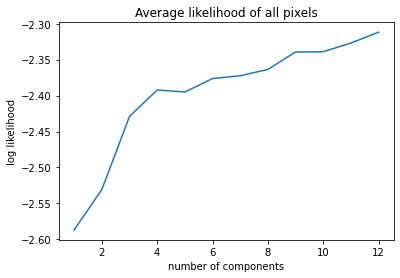

<Figure size 432x288 with 0 Axes>

In [445]:
def plot_likeli_nComp(z, save=None):
    avg_likeli=[]
    for i in range(12):
        gmm = GaussianMixture(n_components=i+1, random_state=4, init_params='kmeans').fit(z)
        avg_likeli.append(gmm.score(z))
    plt.plot(range(1,13), avg_likeli)
    plt.xlabel('number of components')
    plt.ylabel('log likelihood')
    plt.title('Average likelihood of all pixels')
    plt.show()
    
    if save is not None:
        plt.savefig(save)
        
plot_likeli_nComp(z, save='figures/likelihood.tif')

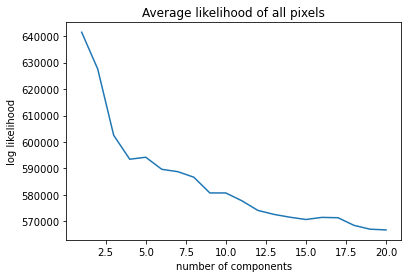

In [473]:
def plot_likeli_nComp(z, save=None):
    avg_likeli=[]
    for i in range(20):
        gmm = GaussianMixture(n_components=i+1, random_state=4, init_params='kmeans').fit(z)
        avg_likeli.append(gmm.bic(z))
    plt.plot(range(1,21), avg_likeli)
    plt.xlabel('number of components')
    plt.ylabel('log likelihood')
    plt.title('Average likelihood of all pixels')
    plt.show()
    
    if save is not None:
        plt.savefig(save)
        
plot_likeli_nComp(z)

In [874]:
h = new_dataset.shape[0]
w = new_dataset.shape[1]

#gmm = GaussianMixture(n_components=5, random_state=4, init_params='kmeans').fit(z)
#gmm = KMeans(n_clusters=8, random_state=3).fit(z)
gmm = GaussianMixture(n_components=8, random_state=4, init_params='kmeans').fit(z)

## Visualization latent space

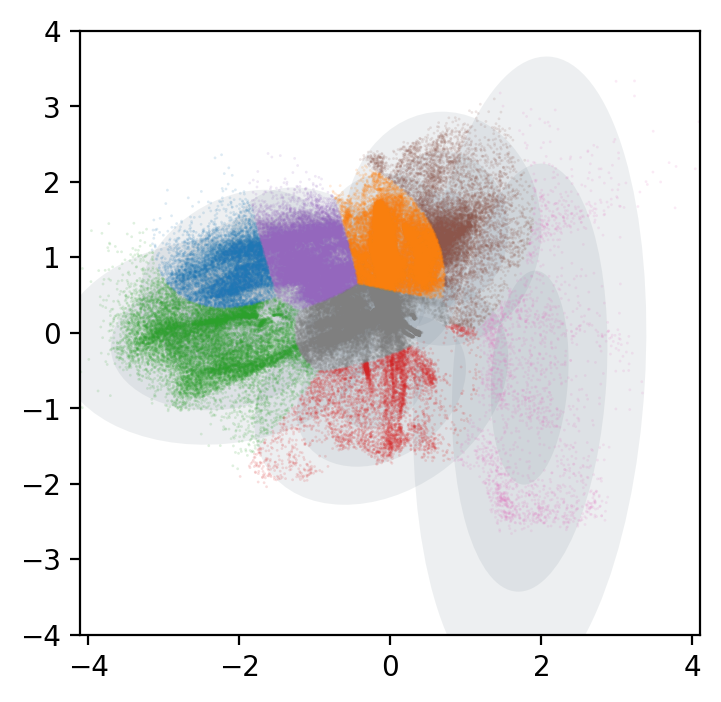

In [884]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gm, X, ax=None, save=None):
    fig, axs = plt.subplots(1,1,figsize=(4,4),dpi=200)
    ax = axs or plt.gca()
    label = gm.predict(X)
    
    ax.scatter(X[:, 0], X[:, 1], c=label, s=1., zorder=2,alpha=.15, linewidths=0, cmap='tab10', norm=mpl.colors.Normalize(vmin=0, vmax=10))
    ax.axis('equal')
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    
    w_factor = 0.2 / gm.weights_.max()
    for pos, covar, w in zip(gm.means_, gm.covariances_, gm.weights_):
        draw_ellipse(pos, covar, alpha= 0.12, facecolor='slategrey', zorder=-10)
    if save is not None:
        fig.savefig(save, bbox_inches = 'tight', pad_inches=0.01)
        
plot_gmm(gmm, z, ax=None, save='figures/latent.tif')

## Pixel distribution for each phase

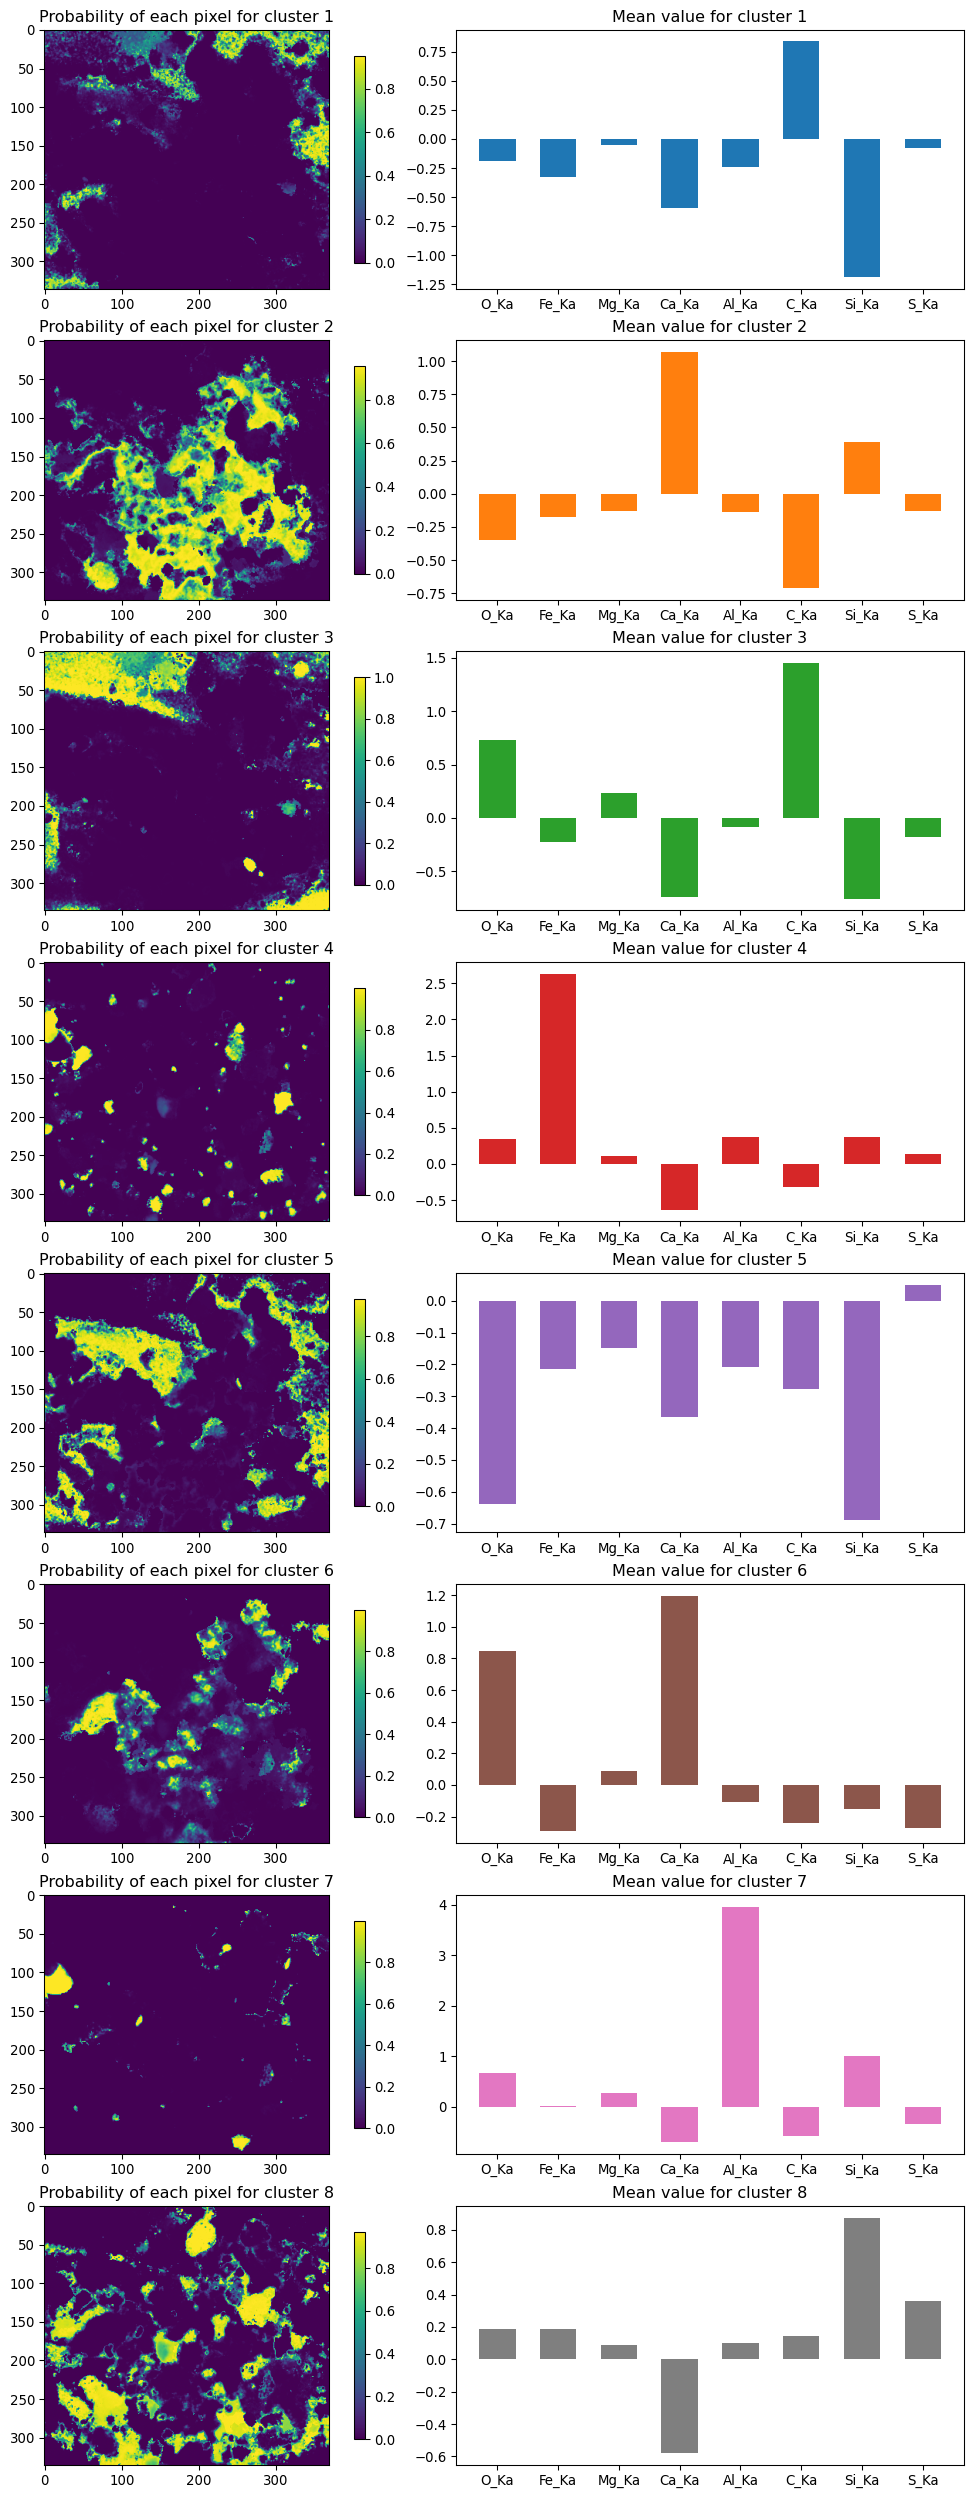

In [885]:
def plot_gm_result(gmm, features, features_3d, feature_list, dims,save=None):
    n_component = gmm.n_components
    labels = gmm.predict(z)
    means = []
    for i in range(n_component):
        mean = features[np.where(labels==i)[0]].mean(axis=0)
        means.append(mean.reshape(1,-1))
    mu = np.concatenate(means,axis=0)
    prob_map = gmm.predict_proba(features_3d)

    fig, axs = plt.subplots(n_component, 2, figsize=(14, n_component*4.2),dpi=96)
    fig.subplots_adjust(hspace=0.35, wspace=0.1)
    for i in range(n_component):
        im=axs[i,0].imshow(prob_map[:,i].reshape(dims), cmap='viridis')
        axs[i,0].set_title('Probability of each pixel for cluster '+str(i+1))
        fig.colorbar(im,ax=axs[i,0], shrink=0.8)

        axs[i,1].bar(feature_list, mu[i],width=0.6, color=plt.cm.get_cmap('tab10')(i*0.1))
        axs[i,1].set_title('Mean value for cluster '+str(i+1))
        #axs[i,1].set_xlabel('Elements')
        #axs[i,1].set_ylabel('Intensity')
        #axs[i,1].set_ylim(0,0.6)

    fig.subplots_adjust(wspace=0.05, hspace=0.2)
    plt.show()
    
    if save is not None:
        fig.savefig(save, bbox_inches = 'tight', pad_inches=0.01)

#plot_gm_result(gmm, features, z, feature_list, dims=(h,w))
#bse_feature_list = ['BSE'] + feature_list
#bse_features = bse_dataset
#bse_features = bse_features.reshape(-1,bse_features.shape[2])
plot_gm_result(gmm, features, z, feature_list, dims=(h,w),save='figures/clusters.tif')

## Phase Map

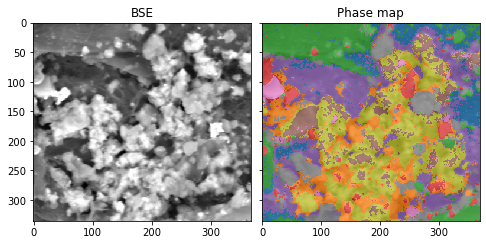

In [686]:
def plotPhaseMap(bse, gmm, features, dim, save=None):
    h, w = dim[0], dim[1]
    img = bse.data
    phase = gmm.predict(features).reshape(h,w)
    #phase_ = np.stack([sns.color_palette("tab10")[i] for i in phase])

    fig, axs = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(8,16))

    axs[0].imshow(img,cmap='gray',interpolation='none')
    axs[0].set_title('BSE')

    im_1 = axs[1].imshow(img,cmap='gray',interpolation='none',alpha=1.)
    im_2 = axs[1].imshow(phase,cmap='tab10',interpolation='none',norm=mpl.colors.Normalize(vmin=0, vmax=10),alpha=0.75)
    axs[1].set_title('Phase map')

    fig.subplots_adjust(wspace=0.05, hspace=0.)
    plt.show()
    
    if save is not None:
        fig.savefig(save, bbox_inches = 'tight', pad_inches=0.02)
  
plotPhaseMap(bse_2xbin, gmm, z, dim=(h,w), save='figures/phase.tif')

## FFT filtered

C:\Users\NANOPA~1\AppData\Local\Temp/ipykernel_2520/2914265285.py:37: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



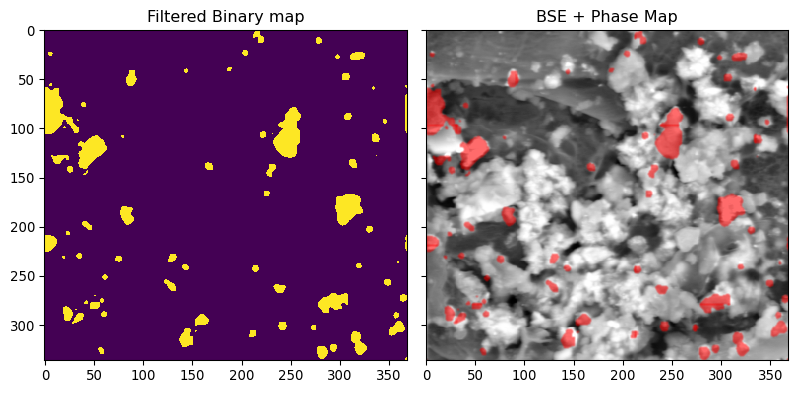

In [689]:
def getFilteredImg(gmm, z, size, num_cluster=0, threshold=0.8):
    phase = gmm.predict_proba(z)[:,num_cluster]
    phase_ = np.where(phase<threshold,0,1).reshape(h,w)
    return phase_

def fourierFilter(filtered_img, bse_img, keep_fraction=0.13, bin_filter_threshold=0.2, color='Red'):
    image_fft = fftpack.fft2(filtered_img)
    image_fft2 = image_fft.copy()

    # Set r and c to be the number of rows and columns of the array.
    r, c = image_fft2.shape

    # Set to zero all rows with indices between r*keep_fraction and
    # r*(1-keep_fraction):
    image_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

    # Similarly with the columns:
    image_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

    # Transformed the filtered image back to real space
    image_new = fftpack.ifft2(image_fft2).real

    image_new_ = np.where(image_new>bin_filter_threshold,1,0)
    image_new_idx = np.where(image_new>bin_filter_threshold)

    fig, axs = plt.subplots(nrows=1,ncols=2, sharex=True,sharey=True,figsize=(10,5), dpi=96)

    axs[0].imshow(image_new_,interpolation='none', alpha=1)
    axs[0].set_title('Filtered Binary map')

    axs[1].imshow(bse_img,cmap='gray',interpolation='none', alpha=1)
    axs[1].scatter(image_new_idx[1], image_new_idx[0], c=color, alpha=0.1, s=1.2)
    axs[1].grid(False)
    axs[1].set_title('BSE + Phase Map')

    fig.subplots_adjust(wspace=0.05)
    fig.show()

bse_img = bse_2xbin.data
filtered_img = getFilteredImg(gmm, z, size=(h,w), num_cluster=3, threshold=0.8)
fourierFilter(filtered_img, bse_img, keep_fraction=0.13, bin_filter_threshold=0.1, color='r')

# Post-processing

## Fe particle

In [859]:
def getPhaseIdx(filtered_phase, keep_fraction=0.13, bin_filter_threshold=0.2):
    image_fft = fftpack.fft2(filtered_phase)
    image_fft2 = image_fft.copy()

    # Set r and c to be the number of rows and columns of the array.
    r, c = image_fft2.shape

    # Set to zero all rows with indices between r*keep_fraction and
    # r*(1-keep_fraction):
    image_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

    # Similarly with the columns:
    image_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

    # Transformed the filtered image back to real space
    image_new = fftpack.ifft2(image_fft2).real

    #image_new_ = np.where(image_new>bin_filter_threshold,1,0)
    image_new_idx = np.where(image_new>bin_filter_threshold)
    
    x_id = image_new_idx[0].reshape(-1,1)
    y_id = image_new_idx[1].reshape(-1,1)
    x_y = np.concatenate([x_id, y_id],axis=1)
    
    return tuple(map(tuple, x_y))

def getProfile(hs_dataset, x_y_idx, num_cluster=3, save=None):
    peak_dict = {'Al_Ka': 1.49, 'C_Ka' : 0.28, 'Ca_Ka': 3.69, 'Cr_Ka': 5.41, 
                 'Fe_Ka': 6.40, 'Fe_La': 0.70, 'Mg_Ka': 1.25, 'N_Ka': 0.39, 
                 'O_Ka': 0.52, 'P_Ka': 2.01, 'S_Ka': 2.31, 'Si_Ka': 1.74}
    peak_list = ['O_Ka','Fe_Ka','Mg_Ka','Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka','S_Ka','Fe_La']
    
    total = list()
    for i in x_y_idx:
        total.append(hs_dataset.data[i].reshape(1,-1))
    total = np.concatenate(total,axis=0)
    
    size = edx_2xbin.axes_manager[2].size
    scale = edx_2xbin.axes_manager[2].scale
    offset = edx_2xbin.axes_manager[2].offset
    x = [((a*scale) + offset) for a in range(0,size)]
    intensity = total.sum(axis=0)
    
    fig, axs = plt.subplots(1,1,figsize=(4,2),dpi=150)
    
    axs.set_xticks(np.arange(0, 11, step=1))
    axs.set_yticks(np.arange(0, int(intensity.max().round())+1, step=int((intensity.max()/5).round())))
    
    axs.set_xticklabels(np.arange(0, 11, step=1), fontsize=8)
    axs.set_yticklabels(np.arange(0,  int(intensity.max().round())+1, step=int((intensity.max()/5).round())), fontsize=8)
    
    axs.set_xlim(offset,10)
    axs.set_xlabel('Energy axis / keV', fontsize=10)
    axs.set_ylabel('X-rays / Counts', fontsize=10)
    
    axs.plot(x, intensity, linewidth=1,color=sns.color_palette()[num_cluster])
    
    zero_energy_idx = np.where(np.array(x).round(2)==0)[0][0]
    for el in peak_list:
        mx = total.sum(axis=0)[zero_energy_idx:][int(peak_dict[el]*100)+1]
        axs.vlines(peak_dict[el], 0, int(0.9*mx), linewidth =0.7, color = 'grey', linestyles='dashed')
        axs.text(peak_dict[el]-0.125, mx+(int(intensity.max().round())/20), el, rotation='vertical', fontsize=5.5)
        
    plt.show()
        
    if save is not None:
        fig.savefig(save, bbox_inches = 'tight', pad_inches=0.02)

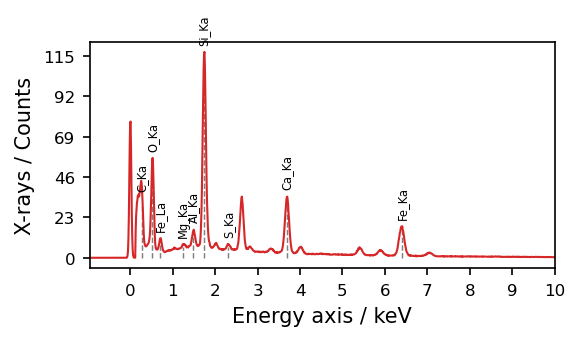

In [860]:
filtered_img = getFilteredImg(gmm, z, size=(h,w), num_cluster=3, threshold=0.8)
x_y_idx = getPhaseIdx(filtered_img)
getProfile(edx_2xbin, x_y_idx, num_cluster=3, save='figures/Fe-particles_intensity.tif')

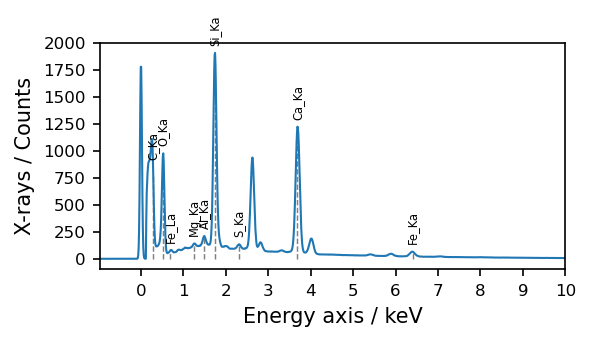

In [793]:
def plotSumProfile(hs_dataset,save=None): 
    peak_dict = {'Al_Ka': 1.49, 'C_Ka' : 0.28, 'Ca_Ka': 3.69, 'Cr_Ka': 5.41, 
                 'Fe_Ka': 6.40, 'Fe_La': 0.70, 'Mg_Ka': 1.25, 'N_Ka': 0.39, 
                 'O_Ka': 0.52, 'P_Ka': 2.01, 'S_Ka': 2.31, 'Si_Ka': 1.74}
    peak_list = ['O_Ka','Fe_Ka','Mg_Ka','Ca_Ka', 'Al_Ka', 'C_Ka', 'Si_Ka','S_Ka','Fe_La']
    
    size = edx_2xbin.axes_manager[2].size
    scale = edx_2xbin.axes_manager[2].scale
    offset = edx_2xbin.axes_manager[2].offset
    x = [((a*scale) + offset) for a in range(0,size)]
    
    fig, axs = plt.subplots(1,1,figsize=(4,2),dpi=150)
    
    axs.set_xticks(np.arange(0, 11, step=1))
    axs.set_yticks(np.arange(0, 2001, step=250))
    
    axs.set_xticklabels(np.arange(0, 11, step=1), fontsize=8)
    axs.set_yticklabels(np.arange(0, 2001, step=250), fontsize=8)
    
    axs.set_xlim(offset,10)
    axs.set_xlabel('Energy axis / keV', fontsize=10)
    axs.set_ylabel('X-rays / Counts', fontsize=10)
    
    axs.plot(x, hs_dataset.sum().data,linewidth=1,color=sns.color_palette()[0])
    
    zero_energy_idx = np.where(np.array(x).round(2)==0)[0][0]
    for el in peak_list:
        mx = hs_dataset.sum().data[zero_energy_idx:][int(peak_dict[el]*100)+1]
        axs.vlines(peak_dict[el], 0, int(0.9*mx), linewidth =0.7, color = 'grey', linestyles='dashed')
        axs.text(peak_dict[el]-0.125, mx+100, el, rotation='vertical', fontsize=5.5)
        
    plt.show()
    
    if save is not None:
        fig.savefig(save, bbox_inches = 'tight', pad_inches=0.02)

plotSumProfile(edx_2xbin,save='figures/total_intensity.tif')

## Al particle

C:\Users\NANOPA~1\AppData\Local\Temp/ipykernel_2520/2914265285.py:37: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



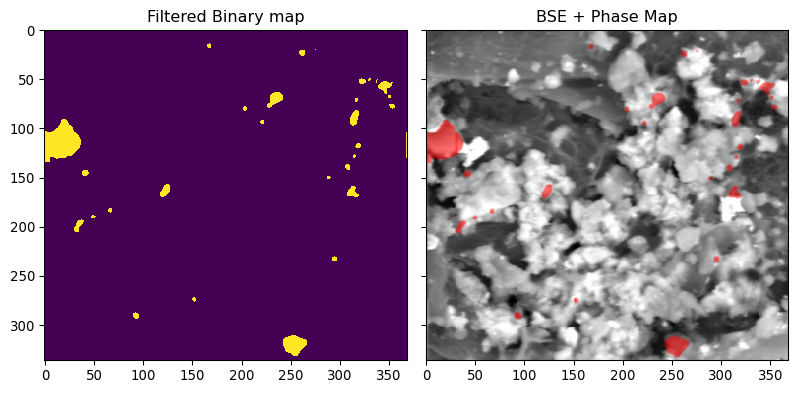

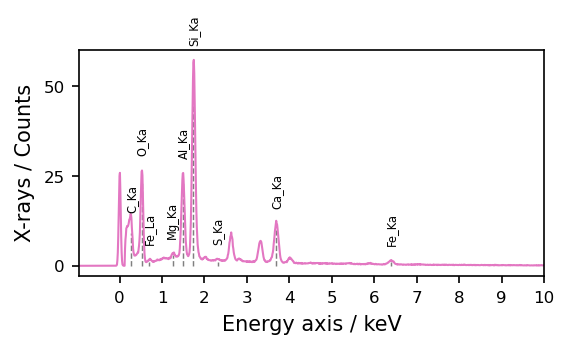

In [816]:
bse_img = bse_2xbin.data
filtered_img = getFilteredImg(gmm, z, size=(h,w), num_cluster=6, threshold=0.8)
fourierFilter(filtered_img, bse_img, keep_fraction=0.13, bin_filter_threshold=0.2, color='r')
x_y_idx = getPhaseIdx(filtered_img)

getProfile(edx_2xbin, x_y_idx, num_cluster=6, save='figures/Al-particles_intensity.tif')

## CaO

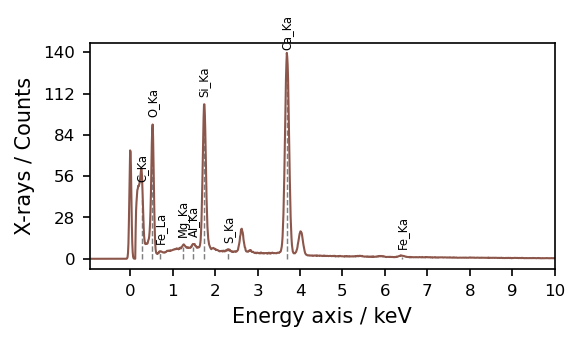

In [862]:
bse_img = bse_2xbin.data
filtered_img = getFilteredImg(gmm, z, size=(h,w), num_cluster=5, threshold=0.8)
#fourierFilter(filtered_img, bse_img, keep_fraction=0.13, bin_filter_threshold=0.2, color='r')
x_y_idx = getPhaseIdx(filtered_img)

getProfile(edx_2xbin, x_y_idx, num_cluster=5, save='figures/CaO_intensity.tif')

## Ca-rich

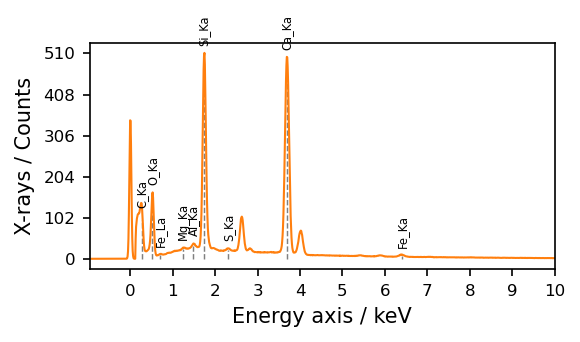

In [861]:
bse_img = bse_2xbin.data
filtered_img = getFilteredImg(gmm, z, size=(h,w), num_cluster=1, threshold=0.8)
#fourierFilter(filtered_img, bse_img, keep_fraction=0.13, bin_filter_threshold=0.2, color='r')
x_y_idx = getPhaseIdx(filtered_img)

getProfile(edx_2xbin, x_y_idx, num_cluster=1, save='figures/Ca-rich_intensity.tif')

# Fe 

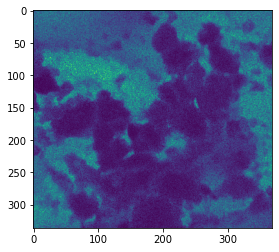

In [882]:
plt.imshow(edx_norm.get_lines_intensity(['Cl_Ka'])[0].data)

In [883]:
edx_norm.get_lines_intensity(['Cl_Ka'])

[<BaseSignal, title: X-ray line intensity of EDX: Cl_Ka at 2.62 keV, dimensions: (369, 336|)>]